In [7]:
using LinearAlgebra
using PyPlot
using Random
using NPZ
using Dates

# projection function onto the design space
function proj(x)
    a = x[1:p*k]
    b = x[(1:k) .+ (p*k)]
    
    a = reshape(a,p,k)
    a = max.(a,design[:,1])
    a = min.(a,design[:,2])
    a = reshape(a,p*k)
    
    u = sort(b, rev=true)
    j = k
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    
    return [a;b]
end

function proj2(x)
    x = max.(x,design2[:,1])
    x = min.(x,design2[:,2])
    return x
end

function pso2(xx)
    #initialize
    #srand(1992)
    path2 = zeros(niter2)
    tau2 = 0.9:(-0.5/niter2):0.4
    v2 = zeros(nptc2, p2)
    ptc2 = rand(nptc2, p2)
    for j2 in 1:p2
            ptc2[:,j2] = (design2[j2,2] - design2[j2,1]) * ptc2[:,j2] .+ design2[j2,1]
    end
    pbesth2 = zeros(nptc2)
    pbest2 = ptc2
    for j2 in 1:nptc2
        pbesth2[j2] = obj(xx,pbest2[j2,:])
    end
    gbesth2 = findmax(pbesth2)[1]
    gbest2 = pbest2[findmax(pbesth2)[2],:]

    #iterate
    for i2 in 1:niter2 # iteration number
        for j2 in 1:nptc2 # particle number
            g12 = rand(p2)
            g22 = rand(p2)
            v2[j2,:] = tau2[i2] .*v2[j2,:] + 2 .* g12 .*(pbest2[j2,:]-ptc2[j2,:]) + 2 .* g22 .*(gbest2-ptc2[j2,:])
            ptc2[j2,:] = ptc2[j2,:] + v2[j2,:]
            ptc2[j2,:] = proj2(ptc2[j2,:])
            fit2 = obj(xx,ptc2[j2,:])
            if fit2 > gbesth2
                gbesth2 = pbesth2[j2] = fit2
                gbest2 = pbest2[j2,:] = ptc2[j2,:]
            elseif fit2 > pbesth2[j2]
                pbesth2[j2] = fit2
                pbest2[j2,:] = ptc2[j2,:]
            end
        end
        path2[i2] = gbesth2
    end
    return [gbesth2; gbest2; path2]
end

function pso()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, p*k+k)
    x = rand(nptc,p*k)
    for j in 1:p
        x[:,p*(1:k).+(j-p)] = (design[j,2]-design[j,1]) * x[:,p*(1:k).+(j-p)] .+ design[j,1]
    end    
    w = randexp(nptc,k)
    for j in 1:nptc
            w[j,:] = w[j,:] ./ sum(w[j,:])
    end
    ptc = hcat(x,w)
    pbest = ptc
    pbesth = zeros(nptc)
    for j in 1:nptc
        pbesth[j] = pso2(pbest[j,:])[1]
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]

    #iterate
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            g1 = rand(p*k+k)
            g2 = rand(p*k+k)
            v[j,:] = tau[i] .*v[j,:] + 2 .* g1 .*(pbest[j,:]-ptc[j,:]) + 2 .* g2 .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:])
            fit = pso2(ptc[j,:])[1]
            if fit < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit
            elseif fit < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit
            end
        end
        path[i] = gbesth
        print(".")
    end
    
    return [gbesth; gbest; path]
end

pso (generic function with 1 method)

In [8]:
function showsummary(x)
    support = reshape(x[(1:p*k).+1],p,k)
    weight = x[(1:k) .+ (p*k+1)]
    optimum = x[1]
    return [support, weight, optimum]
end

function showplot(x)
    path = x[(1:niter) .+ (p*k+k+1)]
    return plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
end

function showsummary2(x)
    theta = x[(1:p2).+1]
    optimum = x[1]
    return [theta, optimum]
end

function showplot2(x)
    path = x[(1:niter2) .+ (p2+1)]
    return plot(1:niter2, path, color="red", linewidth=2.0, linestyle="solid")
end

showplot2 (generic function with 1 method)

In [9]:
function obj(eta, theta)
    t = theta[1]
    x = eta[1]
    w = eta[2]
    m = w*(x^2-t^2)
    return m
end

obj (generic function with 1 method)

In [10]:
# outer loop
k = 1
nptc = 32
niter = 100
design = [-5 5]
p = size(design)[1]

# inner loop
nptc2 = 64
niter2 = 50
design2 = [-5 5]
p2 = size(design2)[1]

result = pso()
showsummary(result)

....................................................................................................

3-element Array{Any,1}:
   [-4.54836e-8]        
   [1.0]                
 -1.0627600935440425e-10

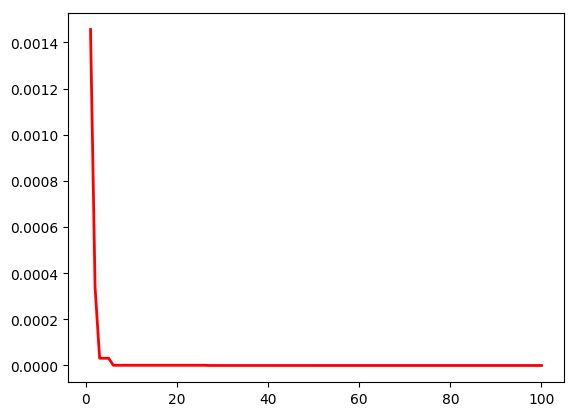

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1047a14da0>

In [11]:
showplot(result)

In [12]:
result2 = pso2([0 1])
showsummary2(result2)

2-element Array{Any,1}:
   [1.36574e-6]         
 -1.8652338756901836e-12

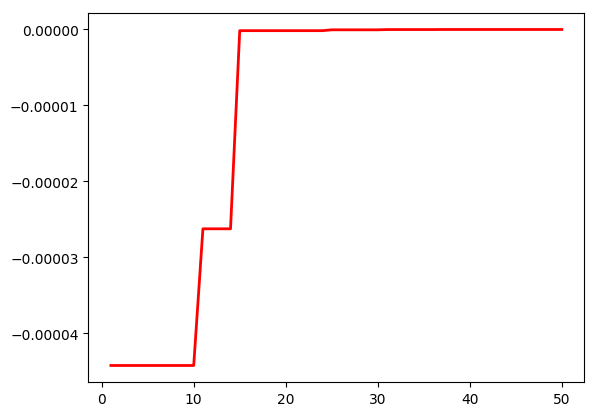

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f104df14f98>

In [13]:
showplot2(result2)

In [14]:
result[2:3]

2-element Array{Float64,1}:
 -4.548359346665323e-8
  1.0                 

In [15]:
result2 = pso2(result[2:3])
showsummary2(result2)

2-element Array{Any,1}:
  [3.75863e-9]         
 2.0546299581687237e-15

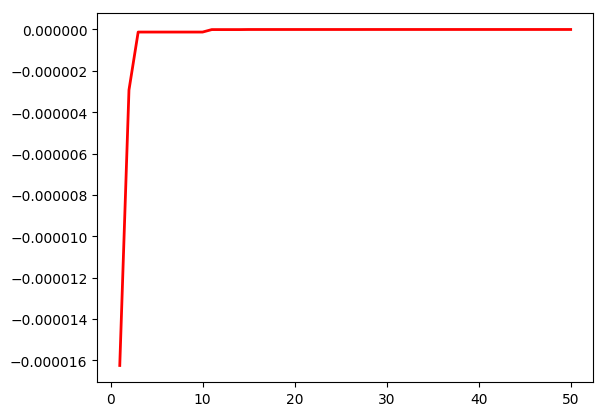

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f104de89710>

In [16]:
showplot2(result2)

In [17]:
result[3]

1.0

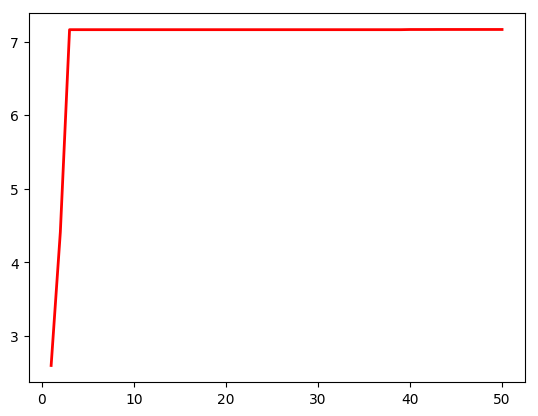

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f104761ba90>

In [21]:
function obj(eta, theta)
    x = theta[1]
    m = -x^4 + 2x^3 - 0.5 + (x-2)^2 + x + 2
    return m
end

# inner loop
nptc2 = 3
niter2 = 50
design2 = [-5 5]
p2 = size(design2)[1]

pso2(1)
showplot2(pso2(1))